# DFT + Wannier90 Pipeline for NIEL Calculations

flow: check dependencies -> import libs -> set config -> load dataset -> generate QE input files (SCF & NSCF) -> run DFT -> generate Wannier90 input -> run Wannier90 -> parse tight-binding hamiltonian -> compute NIEL for OMERE

## 1. Dependencies and imports

In [1]:
import importlib, shutil, os
import pandas as pd
from IPython.display import display

check_data = []

for pkg in ["numpy", "ase", "jarvis", "nglview", "seaborn", "pandas"]:
    try:
        mod = importlib.import_module(pkg)
        version = getattr(mod, '__version__', 'N/A')
        check_data.append({'Category': 'Package', 'Item': pkg, 'Status': 'OK', 'Details': version})
    except ImportError:
        check_data.append({'Category': 'Package', 'Item': pkg, 'Status': 'MISSING', 'Details': 'Not installed'})

for exe in ["pw.x", "wannier90.x", "pw2wannier90.x", "mpirun"]:
    found = shutil.which(exe)
    status = 'OK' if found else 'MISSING'
    details = found if found else 'Not in PATH'
    check_data.append({'Category': 'Executable', 'Item': exe, 'Status': status, 'Details': details})

pseudo_dir = "/usr/share/espresso/pseudo"
if os.path.isdir(pseudo_dir):
    num_pseudos = len([f for f in os.listdir(pseudo_dir) if f.endswith(('.upf', '.UPF'))])
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'Directory', 'Status': 'OK', 'Details': pseudo_dir})
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'File count', 'Status': 'OK', 'Details': f'{num_pseudos} files'})
else:
    check_data.append({'Category': 'Pseudopotentials', 'Item': 'Directory', 'Status': 'MISSING', 'Details': 'Not found'})

display(pd.DataFrame(check_data))

,Category,Item,Status,Details
0,Package,numpy,OK,1.26.4
1,Package,ase,OK,3.27.0
2,Package,jarvis,OK,2026.1.10
3,Package,nglview,OK,4.0
4,Package,seaborn,OK,0.13.2
5,Package,pandas,OK,3.0.0
6,Executable,pw.x,OK,/home/vm/miniconda3/envs/DSI/bin/pw.x
7,Executable,wannier90.x,OK,/home/vm/miniconda3/envs/DSI/bin/wannier90.x
8,Executable,pw2wannier90.x,OK,/home/vm/miniconda3/envs/DSI/bin/pw2wannier90.x
9,Executable,mpirun,OK,/home/vm/miniconda3/envs/DSI/bin/mpirun


In [2]:
import os
import sys

# ensure conda libs are in ld_library_path for subprocess calls
conda_prefix = os.environ.get('CONDA_PREFIX', os.path.expanduser('~/miniconda3/envs/DSI'))
lib_path = os.path.join(conda_prefix, 'lib')
os.environ['LD_LIBRARY_PATH'] = lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')

import numpy as np
import pandas as pd
from IPython.display import display, HTML
from jarvis.db.figshare import data as jarvis_data
from jarvis.core.atoms import Atoms as JarvisAtoms
from ase import Atoms as AseAtoms
import nglview as nv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import subprocess
import multiprocessing

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

## 2. Config

In [3]:
JARVIS_DATABASE = "dft_3d"
WORK_DIR = os.path.join(os.getcwd(), "calculations")
os.makedirs(WORK_DIR, exist_ok=True)

QE_PSEUDOPOTENTIALS_DIR = pseudo_dir
QE_EXECUTABLE = shutil.which("pw.x") or shutil.which("pw")
WANNIER90_EXECUTABLE = shutil.which("wannier90.x") or shutil.which("wannier90")
PW2WANNIER90_EXECUTABLE = shutil.which("pw2wannier90.x") or shutil.which("pw2wannier90")
MPI_EXECUTABLE = shutil.which("mpirun") or shutil.which("mpiexec")

# memory constraints - adjust SYSTEM_RAM_GB for your machine
SYSTEM_RAM_GB = 16
MAX_ATOMS = {8: 2, 16: 6, 32: 12, 64: 25, 128: 50}.get(SYSTEM_RAM_GB, int(SYSTEM_RAM_GB * 0.4))

OCCUPATIONS = "smearing"
SMEARING = "cold"
DEGAUSS = 0.01

# precision settings
ENABLE_SOC = True       # spin-orbit coupling (auto-detects FR pseudopotentials)
ENABLE_VDW = True       # van der Waals correction (DFT-D3, negligible cost)
ENABLE_RELAX = True     # structural relaxation (vc-relax) before SCF
CONV_THR_RELAX = 1.0e-6 # convergence threshold for relaxation
CONV_THR_SCF = 1.0e-10  # tighter convergence for SCF (was 1.0e-8)
FORC_CONV_THR = 1.0e-4  # force convergence for relaxation (Ry/bohr)
PRESS_CONV_THR = 0.1    # pressure convergence for relaxation (kbar)

print(f"system ram: {SYSTEM_RAM_GB} GB, max atoms: {MAX_ATOMS}")
print(f"executables: pw.x={QE_EXECUTABLE is not None}, wannier90={WANNIER90_EXECUTABLE is not None}")
print(f"pseudopotentials: {QE_PSEUDOPOTENTIALS_DIR}")
print(f"precision: SOC={ENABLE_SOC}, vdW={ENABLE_VDW}, relax={ENABLE_RELAX}")
print(f"conv_thr: relax={CONV_THR_RELAX}, scf={CONV_THR_SCF}")
print("\n(nprocs, cutoffs, k-points computed after material is loaded)")

system ram: 16 GB, max atoms: 6
executables: pw.x=True, wannier90=True
pseudopotentials: /usr/share/espresso/pseudo
precision: SOC=True, vdW=True, relax=True
conv_thr: relax=1e-06, scf=1e-10

(nprocs, cutoffs, k-points computed after material is loaded)


## 3. Load Material from JARVIS

In [4]:
data = jarvis_data(JARVIS_DATABASE)
candidates = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "calculating_energy_threshold_displacement/candidate_materials.csv"))

MATERIAL_INDEX = 0  # change to process different materials
formula = candidates.iloc[MATERIAL_INDEX]['formula']
mat = next((m for m in data if m.get('formula') == formula), None)
MATERIAL_ID = mat['jid']

print(f"{MATERIAL_INDEX}: {formula} -> {MATERIAL_ID}")

jarvis_atoms = JarvisAtoms.from_dict(mat['atoms'])
ase_atoms = AseAtoms(
    symbols=jarvis_atoms.elements,
    positions=jarvis_atoms.cart_coords,
    cell=jarvis_atoms.lattice_mat,
    pbc=True
)

# check if material exceeds memory limits
n_atoms = len(ase_atoms)
if n_atoms > MAX_ATOMS:
    raise MemoryError(
        f"material has {n_atoms} atoms, max supported on {SYSTEM_RAM_GB}GB RAM is {MAX_ATOMS}.\n"
        f"try a smaller material or run on a machine with more memory."
    )

# MPI processes for Quantum ESPRESSO
# QE distributes memory across processes, so MORE processes = LESS ram per process
# small systems: limited by parallelization efficiency (overhead dominates)
# large systems: need MORE processes to distribute memory, not fewer!
available_cores = multiprocessing.cpu_count()
ram_per_core = SYSTEM_RAM_GB / available_cores

if n_atoms <= 2:
    # small systems: parallel efficiency drops with too many cores, but memory is fine
    # use up to half the cores to balance speed vs overhead
    QE_NPROCS = min(available_cores // 2, 4) or 1
elif n_atoms <= 6:
    # medium systems: can use most cores effectively
    QE_NPROCS = min(available_cores - 1, 8)
else:
    # large systems: NEED more processes to distribute memory load
    # each process gets a fraction of the FFT grid
    QE_NPROCS = available_cores

# ensure at least 2GB per process for QE overhead
min_ram_per_proc = 2.0
max_procs_for_ram = max(1, int(SYSTEM_RAM_GB / min_ram_per_proc))
QE_NPROCS = min(QE_NPROCS, max_procs_for_ram)

print(f"atoms: {n_atoms} (max {MAX_ATOMS} for {SYSTEM_RAM_GB}GB RAM)")
print(f"mpi processes: {QE_NPROCS} (of {available_cores} cores, ~{SYSTEM_RAM_GB/QE_NPROCS:.1f}GB per process)")

Obtaining 3D dataset 76k ...
Reference:https://doi.org/10.1016/j.commatsci.2025.114063
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
0: InP -> JVASP-1183
atoms: 2 (max 6 for 16GB RAM)
mpi processes: 4 (of 10 cores, ~4.0GB per process)


In [5]:
elements = list(set(ase_atoms.get_chemical_symbols()))
element_counts = {e: ase_atoms.get_chemical_symbols().count(e) for e in elements}

mat_props = [
    {'Property': 'Material ID', 'Value': MATERIAL_ID},
    {'Property': 'Formula', 'Value': ase_atoms.get_chemical_formula()},
    {'Property': 'Atoms', 'Value': len(ase_atoms)},
    {'Property': 'Elements', 'Value': str(element_counts)},
    {'Property': 'Volume', 'Value': f'{ase_atoms.get_volume():.3f} A^3'},
    {'Property': 'Cell', 'Value': f'{ase_atoms.cell.lengths()[0]:.3f} x {ase_atoms.cell.lengths()[1]:.3f} x {ase_atoms.cell.lengths()[2]:.3f} A'},
]

for key in ['formation_energy_peratom', 'optb88vdw_bandgap', 'spillage']:
    if key in mat and mat[key] is not None:
        val = mat[key]
        mat_props.append({'Property': key, 'Value': f'{val:.4f}' if isinstance(val, (int, float)) else str(val)})

display(pd.DataFrame(mat_props))

,Property,Value
0,Material ID,JVASP-1183
1,Formula,InP
2,Atoms,2
3,Elements,"{'P': 1, 'In': 1}"
4,Volume,52.799 A^3
5,Cell,4.211 x 4.211 x 4.211 A
6,formation_energy_peratom,-0.2243
7,optb88vdw_bandgap,0.3310
8,spillage,na


In [6]:
from ase.build import make_supercell

supercell = make_supercell(ase_atoms, [[2, 0, 0], [0, 2, 0], [0, 0, 2]])
view = nv.show_ase(supercell)
view.add_unitcell()
view.center()
view

NGLWidget()

## 4. Generate Quantum ESPRESSO Input Files (SCF & NSCF)

In [7]:
# parse upf pseudopotential header to extract valence, angular momentum, type
def parse_upf_header(upf_path):
    info = {'z_valence': None, 'l_max': None, 'pseudo_type': None, 'element': None, 'has_so': False}
    with open(upf_path, 'r') as f:
        content = f.read()
    header_match = re.search(r'<PP_HEADER([^>]+)>', content, re.DOTALL)
    if header_match:
        header = header_match.group(1)
        for key in ['z_valence', 'l_max', 'pseudo_type', 'element']:
            match = re.search(rf'{key}="([^"]+)"', header)
            if match:
                val = match.group(1).strip()
                info[key] = float(val) if key in ['z_valence', 'l_max'] else val
        # detect fully-relativistic pseudopotentials for SOC
        so_match = re.search(r'has_so="(\w)"', header)
        if so_match:
            info['has_so'] = so_match.group(1).upper() == 'T'
        rel_match = re.search(r'relativistic="(\w+)"', header)
        if rel_match:
            info['is_full_relativistic'] = rel_match.group(1).lower() == 'full'
        else:
            info['is_full_relativistic'] = False
    return info

# estimate cutoffs from element properties: heavier elements and higher l_max need more
def get_recommended_cutoffs(element, z_valence, l_max, pseudo_type):
    from ase.data import atomic_numbers
    Z = atomic_numbers.get(element, 30)
    row = 1 + (Z > 2) + (Z > 10) + (Z > 18) + (Z > 36) + (Z > 54) + (Z > 86)
    
    base_wfc = 30.0
    if l_max is not None:
        base_wfc += l_max * 8.0  # d/f orbitals need higher cutoffs
    if z_valence is not None:
        base_wfc += z_valence * 1.5  # more electrons = higher cutoff
    base_wfc += (row - 1) * 3.0
    
    # paw needs higher rho multiplier
    rho_multiplier = 10.0 if pseudo_type == 'PAW' else 4.0
    # no artificial caps — let the physics determine the cutoff
    ecutwfc = max(40.0, round(base_wfc / 5) * 5)
    ecutrho = ecutwfc * rho_multiplier
    return ecutwfc, ecutrho

# classify elements by dominant orbital character for wannier projections
def get_element_orbital_type(element):
    d_metals = {'Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
                'Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd',
                'Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg'}
    f_metals = {'La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu',
                'Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf'}
    s_metals = {'Li','Na','K','Rb','Cs','Fr'}
    sp_metals = {'Be','Mg','Ca','Sr','Ba','Ra','Al','Ga','In','Tl'}
    
    if element in d_metals:
        return 'd', 5
    elif element in f_metals:
        return 'f', 7
    elif element in s_metals:
        return 's', 1
    elif element in sp_metals:
        return 'sp', 2
    else:
        return 'sp3', 4  # main group defaults to sp3 hybridized

# calculate k-point grid from cell size (smaller cell = more k-points)
def get_kpoints_from_cell(cell, density=0.10, max_total_kpts=500):
    recip = 2 * np.pi * np.linalg.inv(cell).T
    recip_lengths = np.linalg.norm(recip, axis=1)
    kpts = [max(1, int(np.ceil(length / density))) for length in recip_lengths]
    
    # scale down proportionally if exceeding max
    total = kpts[0] * kpts[1] * kpts[2]
    if total > max_total_kpts:
        scale = (max_total_kpts / total) ** (1/3)
        kpts = [max(1, int(k * scale)) for k in kpts]
    return kpts

# collect pseudopotentials and compute all dynamic parameters
elements = list(set(ase_atoms.get_chemical_symbols()))
pseudos = {}
pp_info = {}
cutoffs_wfc = []
cutoffs_rho = []
all_have_soc = True  # track whether all elements have FR pseudopotentials

for e in elements:
    cands = [f for f in os.listdir(QE_PSEUDOPOTENTIALS_DIR) 
             if f.lower().endswith('.upf') and f.startswith(e + '.')]
    if not cands:
        raise FileNotFoundError(f"no pseudopotential for '{e}' in {QE_PSEUDOPOTENTIALS_DIR}")
    # prefer non-semicore version for standard calculations
    non_sp = [c for c in cands if '_sp' not in c]
    pp_file = non_sp[0] if non_sp else cands[0]
    pseudos[e] = pp_file
    
    pp_path = os.path.join(QE_PSEUDOPOTENTIALS_DIR, pp_file)
    info = parse_upf_header(pp_path)
    pp_info[e] = info
    
    if not info.get('has_so', False):
        all_have_soc = False
    
    wfc, rho = get_recommended_cutoffs(e, info['z_valence'], info['l_max'], info['pseudo_type'])
    cutoffs_wfc.append(wfc)
    cutoffs_rho.append(rho)

# resolve SOC: only enable if requested AND all pseudopotentials support it
SOC_ACTIVE = ENABLE_SOC and all_have_soc
if ENABLE_SOC and not all_have_soc:
    missing_soc = [e for e in elements if not pp_info[e].get('has_so', False)]
    print(f"WARNING: SOC requested but pseudopotentials are scalar-relativistic for: {missing_soc}")
    print(f"  -> SOC disabled. For SOC, install fully-relativistic pseudopotentials from")
    print(f"     PseudoDojo (http://www.pseudo-dojo.org/) or SSSP with FR variants.")
    print(f"     Look for files with has_so='T' or relativistic='full'.\n")

# use max cutoffs across all elements (qe requires consistent values)
ECUTWFC = max(cutoffs_wfc)
ECUTRHO = max(cutoffs_rho)

# compute wannier function count
num_wann = 0
orbital_info = {}
for e in elements:
    n_atoms = ase_atoms.get_chemical_symbols().count(e)
    orb_type, orb_count = get_element_orbital_type(e)
    orbital_info[e] = {'type': orb_type, 'count': orb_count, 'atoms': n_atoms}
    num_wann += orb_count * n_atoms

NUM_WANNIER_FUNCTIONS = num_wann
K_POINTS = get_kpoints_from_cell(ase_atoms.cell)

print("pseudopotentials and parameters:")
for e in elements:
    info = pp_info[e]
    wfc, rho = get_recommended_cutoffs(e, info['z_valence'], info['l_max'], info['pseudo_type'])
    orb = orbital_info[e]
    soc_str = "FR" if info.get('has_so', False) else "SR"
    print(f"  {e}: {pseudos[e]} ({soc_str}), z={info['z_valence']}, l_max={int(info['l_max']) if info['l_max'] else '?'}, "
          f"cutoff={wfc}/{rho} Ry, orbitals={orb['type']}x{orb['atoms']}")

print(f"\ncutoffs: {ECUTWFC}/{ECUTRHO} Ry")
print(f"k-points (scf): {K_POINTS} = {K_POINTS[0]*K_POINTS[1]*K_POINTS[2]} pts")
print(f"wannier functions: {NUM_WANNIER_FUNCTIONS}")
print(f"SOC: {'ACTIVE' if SOC_ACTIVE else 'DISABLED'}, vdW: {ENABLE_VDW}, relax: {ENABLE_RELAX}")

# nscf k-grid: same as scf (doubling causes OOM for large systems)
# wannier90 interpolates anyway, so dense scf grid is sufficient
nk_nscf = K_POINTS
nkpts_nscf = nk_nscf[0] * nk_nscf[1] * nk_nscf[2]
print(f"k-points (nscf): {nk_nscf} = {nkpts_nscf} pts")
kpoints_nscf = [[i/nk_nscf[0], j/nk_nscf[1], k/nk_nscf[2]] 
                for k in range(nk_nscf[2]) 
                for j in range(nk_nscf[1]) 
                for i in range(nk_nscf[0])]

def generate_qe_input(calc_type, k_grid, atoms, material_id, pseudos, nbnd=None):
    """Generate QE input for scf, nscf, or vc-relax calculations."""
    is_relax = calc_type == 'vc-relax'
    
    lines = [
        f"&CONTROL\n  calculation='{calc_type}'\n  prefix='{material_id}'\n",
        f"  outdir='./tmp'\n  pseudo_dir='{QE_PSEUDOPOTENTIALS_DIR}'\n",
    ]
    if is_relax:
        lines.append("  forc_conv_thr={:.1e}\n".format(FORC_CONV_THR))
        lines.append("  etot_conv_thr=1.0d-6\n")
    lines.append("/\n")
    
    lines.append(f"&SYSTEM\n  ibrav=0\n  nat={len(atoms)}\n  ntyp={len(elements)}\n")
    lines.append(f"  ecutwfc={ECUTWFC}\n  ecutrho={ECUTRHO}\n")
    lines.append(f"  occupations='{OCCUPATIONS}'\n  smearing='{SMEARING}'\n  degauss={DEGAUSS}\n")
    
    # spin-orbit coupling
    if SOC_ACTIVE:
        lines.append("  noncolin=.true.\n  lspinorb=.true.\n")
    
    # van der Waals correction (DFT-D3)
    if ENABLE_VDW:
        lines.append("  vdw_corr='dft-d3'\n")
    
    if calc_type == 'nscf':
        lines.append("  nosym=.true.\n  noinv=.true.\n")
        if nbnd is not None:
            lines.append(f"  nbnd={nbnd}\n")
    lines.append("/\n")
    
    conv_thr = CONV_THR_RELAX if is_relax else CONV_THR_SCF
    lines.append(f"&ELECTRONS\n  conv_thr={conv_thr:.1e}\n")
    if calc_type == 'nscf':
        lines.append("  diagonalization='cg'\n  diago_full_acc=.true.\n")
    lines.append("/\n")
    
    if is_relax:
        lines.append("&IONS\n  ion_dynamics='bfgs'\n/\n")
        lines.append(f"&CELL\n  cell_dynamics='bfgs'\n  press_conv_thr={PRESS_CONV_THR}\n/\n")
    
    lines.append("ATOMIC_SPECIES\n")
    for e in elements:
        mass = atoms.get_masses()[atoms.get_chemical_symbols().index(e)]
        lines.append(f"  {e}  {mass:.4f}  {pseudos[e]}\n")
    
    lines.append("\nCELL_PARAMETERS angstrom\n")
    for i in range(3):
        lines.append(f"  {atoms.cell[i,0]:16.10f} {atoms.cell[i,1]:16.10f} {atoms.cell[i,2]:16.10f}\n")
    
    lines.append("\nATOMIC_POSITIONS angstrom\n")
    for s, p in zip(atoms.get_chemical_symbols(), atoms.positions):
        lines.append(f"  {s:4s} {p[0]:16.10f} {p[1]:16.10f} {p[2]:16.10f}\n")
    
    if calc_type in ('scf', 'vc-relax'):
        lines.append(f"\nK_POINTS automatic\n  {k_grid[0]} {k_grid[1]} {k_grid[2]}  0 0 0\n")
    else:
        lines.append(f"\nK_POINTS crystal\n  {nkpts_nscf}\n")
        for kpt in kpoints_nscf:
            lines.append(f"  {kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}  1.0\n")
    return ''.join(lines)

qe_relax_input = generate_qe_input('vc-relax', K_POINTS, ase_atoms, MATERIAL_ID, pseudos) if ENABLE_RELAX else None
qe_scf_input = generate_qe_input('scf', K_POINTS, ase_atoms, MATERIAL_ID, pseudos)
qe_nscf_input = generate_qe_input('nscf', nk_nscf, ase_atoms, MATERIAL_ID, pseudos)

  -> SOC disabled. For SOC, install fully-relativistic pseudopotentials from
     PseudoDojo (http://www.pseudo-dojo.org/) or SSSP with FR variants.
     Look for files with has_so='T' or relativistic='full'.

pseudopotentials and parameters:
  P: P.GGA_PBE-JTH.UPF (SR), z=5.0, l_max=1, cutoff=50/500.0 Ry, orbitals=sp3x1
  In: In.GGA_PBE-JTH.UPF (SR), z=13.0, l_max=2, cutoff=80/800.0 Ry, orbitals=spx1

cutoffs: 80/800.0 Ry
k-points (scf): [7, 7, 7] = 343 pts
wannier functions: 6
SOC: DISABLED, vdW: True, relax: True
k-points (nscf): [7, 7, 7] = 343 pts


## 5. Run DFT Calculations

In [8]:
def run_command(cmd, cwd, timeout=None):
    process = subprocess.Popen(
        cmd, shell=True, cwd=cwd,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        text=True, bufsize=1
    )
    output_lines = []
    try:
        for line in process.stdout:
            print(line, end='', flush=True)
            output_lines.append(line)
        process.wait(timeout=timeout)
    except subprocess.TimeoutExpired:
        process.kill()
        raise
    if process.returncode != 0:
        raise RuntimeError(f"command failed with code {process.returncode}")
    return ''.join(output_lines)

def parse_relaxed_structure(output_text, original_atoms):
    """Parse final cell and positions from vc-relax output."""
    # find last CELL_PARAMETERS block
    cell_blocks = list(re.finditer(
        r'CELL_PARAMETERS\s*\(?\s*angstrom\s*\)?\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)\s*\n'
        r'\s*([\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+)',
        output_text, re.IGNORECASE
    ))
    
    # find last ATOMIC_POSITIONS block
    pos_blocks = list(re.finditer(
        r'ATOMIC_POSITIONS\s*\(?\s*angstrom\s*\)?\s*\n((?:\s*\w+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s+[\d\.\-\+eE]+\s*\n?)+)',
        output_text, re.IGNORECASE
    ))
    
    if not cell_blocks or not pos_blocks:
        print("WARNING: could not parse relaxed structure, using original")
        return original_atoms
    
    # parse last cell
    cell_match = cell_blocks[-1]
    cell = np.array([
        [float(x) for x in cell_match.group(1).split()],
        [float(x) for x in cell_match.group(2).split()],
        [float(x) for x in cell_match.group(3).split()],
    ])
    
    # parse last positions
    pos_text = pos_blocks[-1].group(1).strip()
    symbols = []
    positions = []
    for line in pos_text.split('\n'):
        parts = line.split()
        if len(parts) >= 4:
            symbols.append(parts[0])
            positions.append([float(parts[1]), float(parts[2]), float(parts[3])])
    
    relaxed = AseAtoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
    print(f"relaxed cell: {relaxed.cell.lengths()[0]:.4f} x {relaxed.cell.lengths()[1]:.4f} x {relaxed.cell.lengths()[2]:.4f} A")
    print(f"original cell: {original_atoms.cell.lengths()[0]:.4f} x {original_atoms.cell.lengths()[1]:.4f} x {original_atoms.cell.lengths()[2]:.4f} A")
    return relaxed

dft_dir = os.path.join(WORK_DIR, f"dft_{MATERIAL_ID}")
os.makedirs(dft_dir, exist_ok=True)

# clean tmp to avoid stale wavefunction data from previous runs
tmp_dir = os.path.join(dft_dir, "tmp")
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
    print(f"cleaned {tmp_dir}")

# step 0: structural relaxation (vc-relax)
atoms_for_scf = ase_atoms
if ENABLE_RELAX:
    with open(os.path.join(dft_dir, f"{MATERIAL_ID}_relax.in"), 'w') as f:
        f.write(qe_relax_input)
    
    print("running vc-relax...")
    relax_output = run_command(
        f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_relax.in",
        cwd=dft_dir
    )
    
    if 'JOB DONE' in relax_output:
        atoms_for_scf = parse_relaxed_structure(relax_output, ase_atoms)
        # regenerate SCF/NSCF inputs with relaxed structure
        qe_scf_input = generate_qe_input('scf', K_POINTS, atoms_for_scf, MATERIAL_ID, pseudos)
        qe_nscf_input = generate_qe_input('nscf', nk_nscf, atoms_for_scf, MATERIAL_ID, pseudos)
        # must clean tmp so SCF starts fresh (vc-relax leaves intermediate wavefunctions)
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)
        print("using relaxed structure for SCF")
    else:
        print("WARNING: vc-relax did not complete successfully, using original structure")

# step 1: SCF
with open(os.path.join(dft_dir, f"{MATERIAL_ID}_scf.in"), 'w') as f:
    f.write(qe_scf_input)

print("\nrunning scf...")
scf_output = run_command(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_scf.in",
    cwd=dft_dir
)

# determine nscf bands: enough for wannier but capped to avoid s-matrix issues
nbnd_match = re.search(r'number of Kohn-Sham states\s*=\s*(\d+)', scf_output)
scf_nbnd = int(nbnd_match.group(1)) if nbnd_match else NUM_WANNIER_FUNCTIONS
nscf_nbnd = max(scf_nbnd * 2, int(NUM_WANNIER_FUNCTIONS * 1.5))
nscf_nbnd = min(nscf_nbnd, scf_nbnd * 3)
print(f"nscf will use {nscf_nbnd} bands (scf had {scf_nbnd})")

# step 2: NSCF
qe_nscf_input = generate_qe_input('nscf', nk_nscf, atoms_for_scf, MATERIAL_ID, pseudos, nbnd=nscf_nbnd)
with open(os.path.join(dft_dir, f"{MATERIAL_ID}_nscf.in"), 'w') as f:
    f.write(qe_nscf_input)

print("\nrunning nscf...")
run_command(
    f"{MPI_EXECUTABLE} -np {QE_NPROCS} {QE_EXECUTABLE} -in {MATERIAL_ID}_nscf.in",
    cwd=dft_dir
)

cleaned /home/vm/LUMENS-PV/calculating_energy_threshold_displacement/calculations/dft_JVASP-1183/tmp
running vc-relax...

     Program PWSCF v.7.5 starts on  6Feb2026 at  6:37:13 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       4 processor cores
     Number of MPI processes:                 4
     Threads/MPI process:                     1

     MPI processes distributed on     1 nodes
     4363 MiB available memory on the printing compute node when the environment starts

     Rea

'\n     Program PWSCF v.7.5 starts on  6Feb2026 at  6:38:45 \n\n     This program is part of the open-source Quantum ESPRESSO suite\n     for quantum simulation of materials; please cite\n         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);\n         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);\n         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);\n          URL http://www.quantum-espresso.org", \n     in publications or presentations arising from this work. More details at\n     http://www.quantum-espresso.org/quote\n\n     Parallel version (MPI & OpenMP), running on       4 processor cores\n     Number of MPI processes:                 4\n     Threads/MPI process:                     1\n\n     MPI processes distributed on     1 nodes\n     4199 MiB available memory on the printing compute node when the environment starts\n\n     Reading input from JVASP-1183_nscf.in\n\n     Current dimensions of program PWSCF are:\n     Max number 

## 6. Generate Wannier90 Input

In [9]:
seedname = "wan"
nk = nk_nscf  # use same grid as nscf
kpoints = [[i/nk[0], j/nk[1], k/nk[2]] 
           for k in range(nk[2]) for j in range(nk[1]) for i in range(nk[0])]

# use atoms_for_scf directly (same object that generated the QE inputs)
# instead of round-tripping through ASE's espresso-in reader, which can
# introduce tiny numerical differences that cause pw2wannier90 lattice mismatches
wan_atoms = atoms_for_scf
print(f"cell: {wan_atoms.cell.lengths()[0]:.6f} x {wan_atoms.cell.lengths()[1]:.6f} x {wan_atoms.cell.lengths()[2]:.6f} A")

projections = [f"{e}:{orbital_info[e]['type']}" for e in elements]
proj_str = '\n'.join(projections)
print(f"projections: {projections}")

wannier_lines = [
    f"num_wann = {NUM_WANNIER_FUNCTIONS}\n",
    f"num_bands = {nscf_nbnd}\n",
    "num_iter = 200\n",
    "dis_num_iter = 200\n",
    "write_hr = true\n",
    "search_shells = 36\n",
    "kmesh_tol = 0.000100\n",
    f"begin projections\n{proj_str}\nend projections\n",
    "begin unit_cell_cart\nang\n",
]
for i in range(3):
    wannier_lines.append(f"{wan_atoms.cell[i,0]:16.10f} {wan_atoms.cell[i,1]:16.10f} {wan_atoms.cell[i,2]:16.10f}\n")
wannier_lines.append("end unit_cell_cart\n")
wannier_lines.append("begin atoms_frac\n")
for s, p in zip(wan_atoms.get_chemical_symbols(), wan_atoms.get_scaled_positions()):
    wannier_lines.append(f"{s} {p[0]:.10f} {p[1]:.10f} {p[2]:.10f}\n")
wannier_lines.append("end atoms_frac\n")
wannier_lines.append(f"mp_grid = {nk[0]} {nk[1]} {nk[2]}\n")
wannier_lines.append("begin kpoints\n")
for kpt in kpoints:
    wannier_lines.append(f"{kpt[0]:16.10f} {kpt[1]:16.10f} {kpt[2]:16.10f}\n")
wannier_lines.append("end kpoints\n")

wannier_input = ''.join(wannier_lines)
print(f"wannier90: num_wann={NUM_WANNIER_FUNCTIONS}, num_bands={nscf_nbnd}")

cell: 4.185484 x 4.185482 x 4.185519 A
projections: ['P:sp3', 'In:sp']
wannier90: num_wann=6, num_bands=26


## 7. Run Wannier90 Workflow

In [10]:
wan_dir = os.path.join(WORK_DIR, f"wannier_{MATERIAL_ID}")
os.makedirs(wan_dir, exist_ok=True)

# clean stale wannier files so -pp always generates a fresh .nnkp
for ext in ['nnkp', 'mmn', 'amn', 'eig']:
    stale = os.path.join(wan_dir, f"{seedname}.{ext}")
    if os.path.exists(stale):
        os.remove(stale)
        print(f"removed stale {seedname}.{ext}")

with open(os.path.join(wan_dir, f"{seedname}.win"), 'w') as f:
    f.write(wannier_input)

print("wannier90 preprocessing...")
run_command(f"{WANNIER90_EXECUTABLE} -pp {seedname}", cwd=wan_dir)

# verify .nnkp was actually created (wannier90 -pp can fail silently)
nnkp_path = os.path.join(wan_dir, f"{seedname}.nnkp")
if not os.path.exists(nnkp_path):
    raise RuntimeError(
        f"{seedname}.nnkp was not created — wannier90 -pp failed. "
        "Check the .wout file for details (common cause: 'Not enough bvectors found')."
    )

pw2wan_input = f"""&inputpp
  outdir = '{dft_dir}/tmp'
  prefix = '{MATERIAL_ID}'
  seedname = '{seedname}'
  write_mmn = .true.
  write_amn = .true.
  write_unk = .false.
/
"""
with open(os.path.join(wan_dir, "pw2wan.in"), 'w') as f:
    f.write(pw2wan_input)

print("pw2wannier90...")
run_command(f"{PW2WANNIER90_EXECUTABLE} < pw2wan.in", cwd=wan_dir)

print("wannier90...")
run_command(f"{WANNIER90_EXECUTABLE} {seedname}", cwd=wan_dir)

hr_file = os.path.join(wan_dir, f"{seedname}_hr.dat")
with open(hr_file, 'r') as f:
    hr_data = f.read()
print(f"generated {seedname}_hr.dat")

removed stale wan.nnkp
removed stale wan.mmn
removed stale wan.amn
removed stale wan.eig
wannier90 preprocessing...
pw2wannier90...

     Program PW2WANNIER v.7.5 starts on  6Feb2026 at  6:42: 9 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on      10 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                    10

     MPI processes distributed on     1 nodes
     3392 MiB available memory on the printing compute node when the environment 

## 8. Parse Tight-Binding Hamiltonian

In [11]:
# parse wannier90 hr.dat: hopping matrix H(R) for all R vectors
lines = hr_data.strip().split('\n')
num_wann = int(lines[1])
nrpts = int(lines[2])
ndegen_lines = (nrpts + 14) // 15

# degeneracy weights for each R vector
degen = []
for i in range(ndegen_lines):
    degen.extend(map(int, lines[3+i].split()))

hopping = {}
for line in lines[3+ndegen_lines:]:
    parts = line.split()
    if len(parts) < 7:
        continue
    R = (int(parts[0]), int(parts[1]), int(parts[2]))
    i, j = int(parts[3])-1, int(parts[4])-1
    t = float(parts[5]) + 1j*float(parts[6])
    if R not in hopping:
        hopping[R] = np.zeros((num_wann, num_wann), dtype=complex)
    hopping[R][i, j] = t

R_list = list(hopping.keys())
R_degen = {R: degen[i] for i, R in enumerate(R_list)}

print(f"wannier hamiltonian: {num_wann} orbitals, {len(R_list)} R-vectors")

# H(k) = sum_R H(R) * exp(i k.R) / degen(R)
def get_Hk(k):
    Hk = np.zeros((num_wann, num_wann), dtype=complex)
    for R, HR in hopping.items():
        phase = np.exp(2j * np.pi * np.dot(k, R))
        Hk += HR * phase / R_degen[R]
    return 0.5 * (Hk + Hk.conj().T)  # enforce hermiticity

# compute bandwidth
nk_test = 4
kpts_test = [[i/nk_test, j/nk_test, k/nk_test] 
             for i in range(nk_test) for j in range(nk_test) for k in range(nk_test)]
eigs = [np.linalg.eigvalsh(get_Hk(k)) for k in kpts_test]
all_eigs = np.array(eigs).flatten()
bandwidth = all_eigs.max() - all_eigs.min()
print(f"bandwidth: {bandwidth:.3f} eV, band center: {all_eigs.mean():.3f} eV")

wannier hamiltonian: 6 orbitals, 343 R-vectors
bandwidth: 19.725 eV, band center: 5.948 eV


## 9. Generate OMERE NIEL Input

compute non-ionizing energy loss (NIEL) for radiation damage calculations:
- **literature E_d** per sublattice (Nordlund et al. 2018, ASTM E722-14)
- **multi-sublattice** NIEL: weighted sum NIEL = Σ f_i × NIEL_i(E_d,i)
- **relativistic screened Coulomb** cross-section (ZBL screening, McKinley-Feshbach correction)
- **two-body Lindhard** partition function (Z₁,M₁ ↔ Z₂,M₂)
- extended energy range: 0.1–200 MeV with 500 integration points
- outputs in OMERE-compatible format + per-element breakdown

material: InP
avg mass: 72.90 amu, avg Z: 32.0, density: 4.585 g/cm³

per-sublattice displacement thresholds:
  P: Z=15, A=30.97 amu, E_d=8.7 eV, fraction=0.500
  In: Z=49, A=114.82 amu, E_d=8.8 eV, fraction=0.500
computing NIEL for 78 energies from 0.10 to 200.0 MeV
using 500 integration points per energy

  P (Z=15, A=31.0, E_d=8.7 eV, fraction=0.500)... NIEL(10 MeV) = 3.5293e-03 MeV·cm²/g
  In (Z=49, A=114.8, E_d=8.8 eV, fraction=0.500)... NIEL(10 MeV) = 1.9333e-03 MeV·cm²/g

total weighted NIEL(10 MeV) = 2.7313e-03 MeV·cm²/g

saved: /home/vm/LUMENS-PV/omere_inputs/InP_NIEL.dat
saved: /home/vm/LUMENS-PV/omere_inputs/InP_NIEL_breakdown.dat


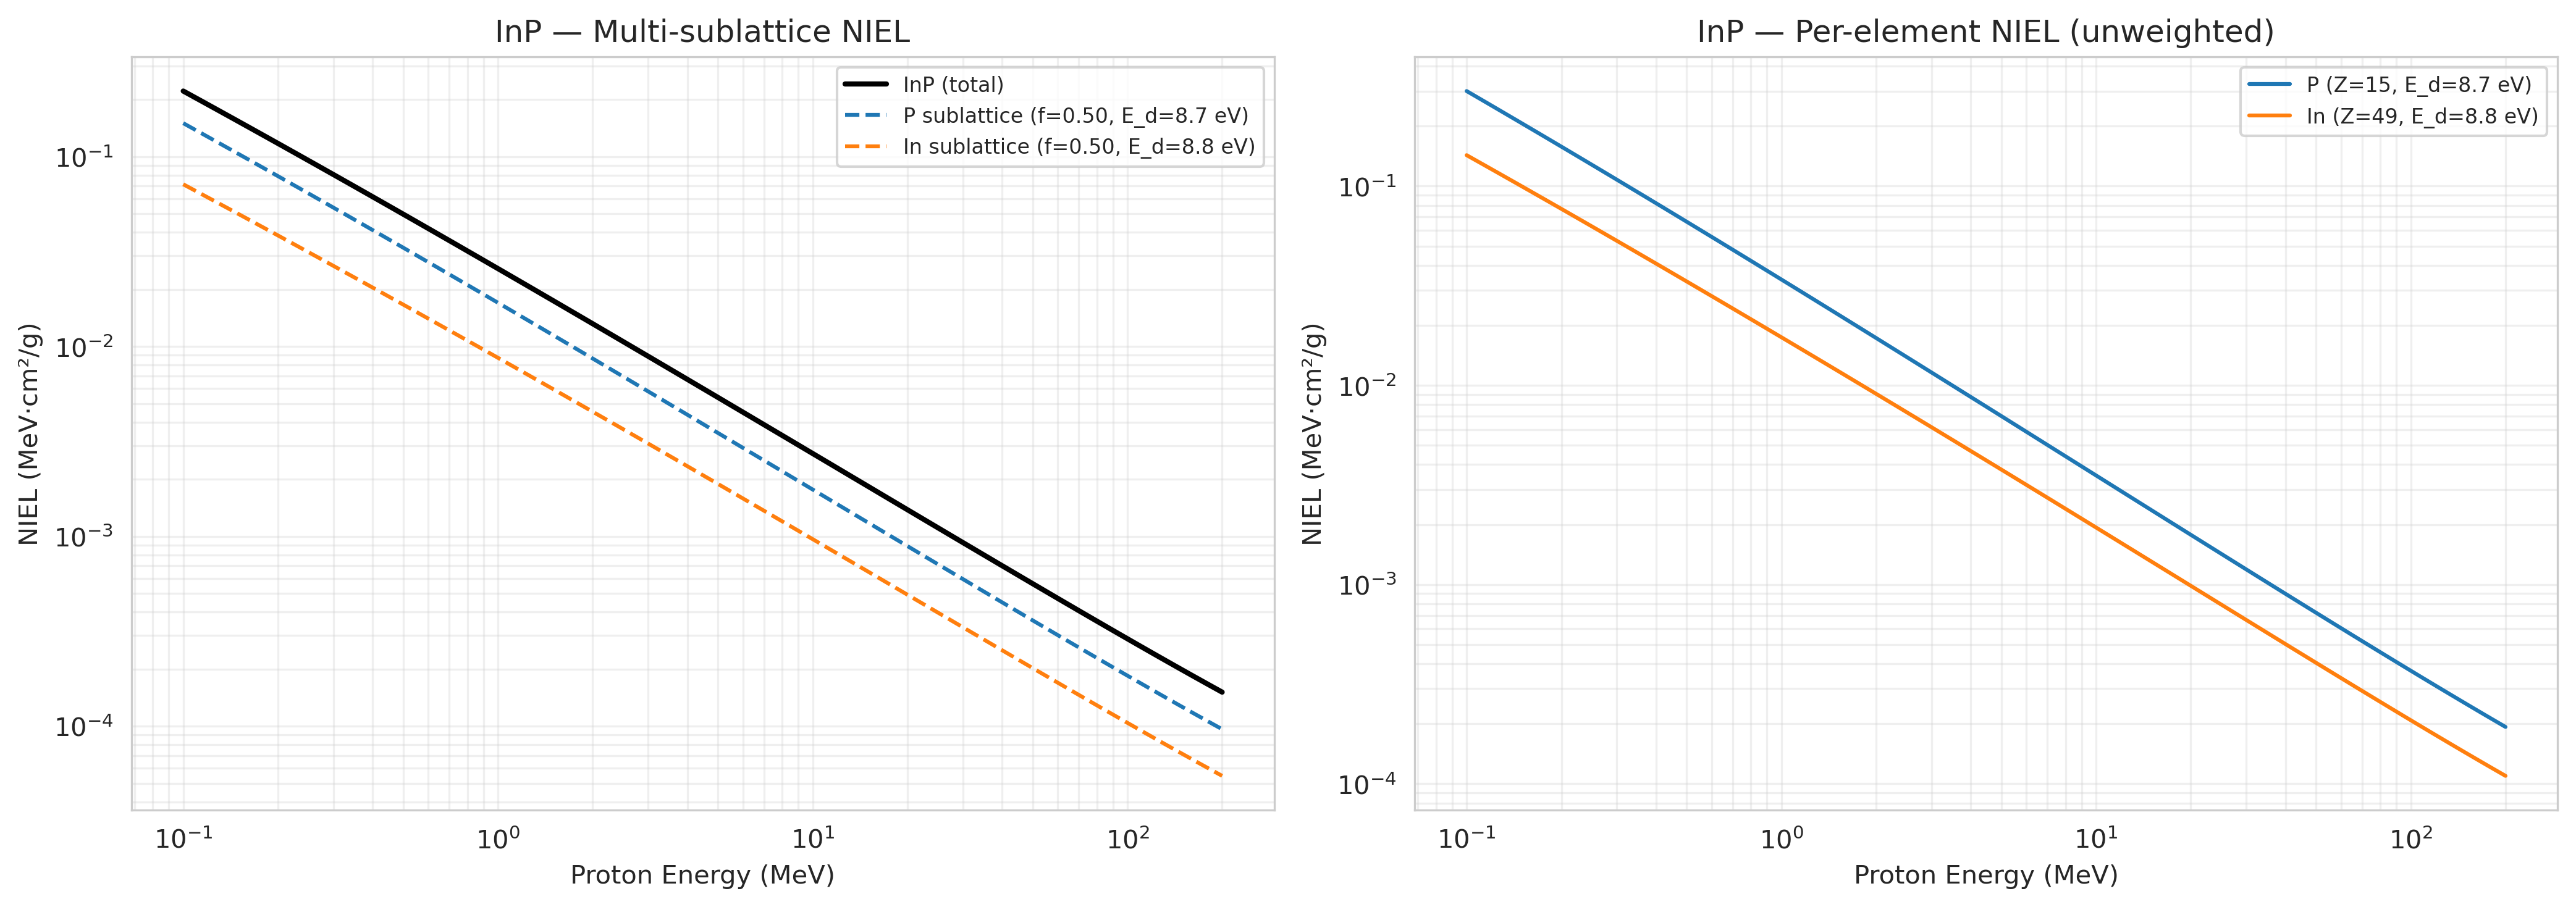


comparison table (selected energies):
   E (MeV)     NIEL total     NIEL_P (wtd)    NIEL_In (wtd)
      0.10     2.2159e-01       1.5007e-01       7.1519e-02
      0.48     5.1406e-02       3.4251e-02       1.7155e-02
      1.00     2.5717e-02       1.6999e-02       8.7187e-03
      4.89     5.5076e-03       3.5797e-03       1.9279e-03
     10.00     2.7313e-03       1.7647e-03       9.6663e-04
     52.22     5.4007e-04       3.4600e-04       1.9407e-04
     97.05     2.9721e-04       1.9003e-04       1.0718e-04
    200.00     1.5117e-04       9.6410e-05       5.4763e-05


In [ ]:
from ase.data import atomic_masses, atomic_numbers

# literature displacement threshold energies (eV) per element
# sources: nordlund et al. (2018) j. nucl. mater. 512, 450-479
#          astm e722-14, aguiar et al., xiao et al. (2009)
#          values are direction-averaged from aimd or experiment
ED_DATABASE = {
    # group iv semiconductors
    'C': 37.0,   # diamond, koike et al.
    'Si': 20.5,  # astm e722-14, dft-md gives 22±2
    'Ge': 14.5,  # loferski & rappaport
    'Sn': 12.0,  # estimated from periodic trends
    # group iii (in iii-v compounds)
    'B': 22.0,   # bn, estimated
    'Al': 16.0,  # alas/aln
    'Ga': 9.4,   # gaas, nordlund
    'In': 8.8,   # inp, nordlund
    'Tl': 7.5,   # estimated from periodic trends
    # group v (in iii-v compounds)
    'N': 22.0,   # gan, xiao et al. 2009 (direction-averaged)
    'P': 8.7,    # inp, nordlund
    'As': 9.8,   # gaas, nordlund
    'Sb': 9.0,   # estimated
    'Bi': 8.0,   # estimated
    # group ii (in ii-vi compounds)
    'Zn': 10.0,  # zno/zns
    'Cd': 8.0,   # cdte/cds
    'Mg': 10.0,  # mgo
    'Be': 15.0,  # beo
    'Ca': 8.0,   # cao
    'Sr': 7.0,   # estimated
    'Ba': 6.5,   # estimated
    'Hg': 6.0,   # estimated
    # group vi (chalcogenides)
    'O': 28.0,   # varies 20-76 by compound, using oxide average
    'S': 7.6,    # cds/zns
    'Se': 7.4,   # cdse/znse
    'Te': 5.5,   # cdte
    # halogens
    'F': 15.0,   # fluorides
    'Cl': 12.0,  # chlorides
    'Br': 10.0,  # bromides
    'I': 8.0,    # iodides
    # alkali metals
    'Li': 12.0,  # li compounds
    'Na': 8.0,
    'K': 6.0,
    'Rb': 5.5,
    'Cs': 5.0,
    # transition metals (3d)
    'Sc': 25.0, 'Ti': 19.0, 'V': 28.0, 'Cr': 28.0,
    'Mn': 26.0, 'Fe': 17.4, 'Co': 22.0, 'Ni': 23.0,
    'Cu': 19.0,
    # transition metals (4d)
    'Y': 20.0, 'Zr': 21.0, 'Nb': 28.0, 'Mo': 33.0,
    'Tc': 30.0, 'Ru': 28.0, 'Rh': 25.0, 'Pd': 16.0, 'Ag': 16.0,
    # transition metals (5d)
    'Hf': 30.0, 'Ta': 34.0, 'W': 55.0, 'Re': 40.0,
    'Os': 35.0, 'Ir': 30.0, 'Pt': 22.0, 'Au': 15.0,
    # rare earths (4f) — limited data, estimated from similar compounds
    'La': 9.0, 'Ce': 9.0, 'Pr': 9.0, 'Nd': 9.0, 'Pm': 9.0,
    'Sm': 9.0, 'Eu': 9.0, 'Gd': 9.0, 'Tb': 9.0, 'Dy': 9.0,
    'Ho': 9.0, 'Er': 9.0, 'Tm': 9.0, 'Yb': 9.0, 'Lu': 9.0,
    # post-transition metals
    'Pb': 8.0, 'Po': 7.0,
    # hydrogen
    'H': 5.0,
}

# fallback: estimate e_d from atomic number if not in database
def get_Ed(element):
    if element in ED_DATABASE:
        return ED_DATABASE[element]
    Z = atomic_numbers.get(element, 30)
    Ed_est = max(5.0, 35.0 - 0.3 * Z)
    print(f"  WARNING: no literature E_d for {element} (Z={Z}), estimating {Ed_est:.1f} eV")
    return Ed_est

# per-element material properties for niel
elem_list = list(set(ase_atoms.get_chemical_symbols()))
elem_data = {}
for e in elem_list:
    Z = atomic_numbers[e]
    A = atomic_masses[Z]
    Ed = get_Ed(e)
    count = ase_atoms.get_chemical_symbols().count(e)
    frac = count / len(ase_atoms)
    elem_data[e] = {'Z': Z, 'A': A, 'Ed': Ed, 'count': count, 'frac': frac}

avg_mass = np.mean(ase_atoms.get_masses())
avg_Z = np.mean([atomic_numbers[s] for s in ase_atoms.get_chemical_symbols()])
density = sum(ase_atoms.get_masses()) / ase_atoms.get_volume() * 1.66054  # g/cm³

print(f"material: {formula}")
print(f"avg mass: {avg_mass:.2f} amu, avg Z: {avg_Z:.1f}, density: {density:.3f} g/cm³")
print(f"\nper-sublattice displacement thresholds:")
for e, d in elem_data.items():
    print(f"  {e}: Z={d['Z']}, A={d['A']:.2f} amu, E_d={d['Ed']:.1f} eV, fraction={d['frac']:.3f}")

# lindhard partition function (proper two-body formulation)
# fraction of recoil energy T going to atomic displacements
# for a pka of (Z1, M1) recoiling in a medium with average (Z2, M2)
def lindhard_partition(T_eV, Z1, M1, Z2=None, M2=None):
    """lindhard-scharff-schiøtt partition function."""
    if Z2 is None:
        Z2 = Z1
    if M2 is None:
        M2 = M1
    
    # reduced lindhard energy
    a_u = 0.8853  # thomas-fermi constant
    Z_eff = (Z1**(2/3) + Z2**(2/3))**0.5
    epsilon = (a_u * 0.529 / (Z1 * Z2 * 14.4)) * (M2 / (M1 + M2)) * T_eV
    
    # lindhard electronic stopping parameter
    k_L = 0.1337 * Z1**(1/6) * (Z1 * Z2 / Z_eff)**0.5 * ((M1 + M2) / M2)**1.5 / (M1**0.5)
    
    # robinson's approximation for the damage energy partition
    g = epsilon + 0.40244 * epsilon**(3/4) + 3.4008 * epsilon**(1/6)
    
    return 1.0 / (1.0 + k_L * g)

# screened relativistic coulomb cross-section (rutherford + zbl screening)
# ref: akkerman & barak (2006), jun et al. (2003)
def calculate_niel_per_element(energies_MeV, Z_target, A_target, Ed_eV,
                                Z_proj=1, A_proj=1.00728,
                                Z_med=None, A_med=None,
                                n_integration=500):
    """calculate niel for protons on a single target element."""
    if Z_med is None:
        Z_med = Z_target
    if A_med is None:
        A_med = A_target
    
    M1_MeV = A_proj * 931.494   # projectile mass in MeV/c²
    M2_MeV = A_target * 931.494 # target mass in MeV/c²
    
    # coulomb constant: k_e * e² = 1.44 MeV·fm = 1.44e-13 MeV·cm
    e2_MeV_cm = 1.44e-13
    
    # zbl screening length (cm) — used only for screening energy
    a_0_cm = 0.529177e-8  # bohr radius in cm
    a_ZBL = 0.8854 * a_0_cm / (Z_proj**0.23 + Z_target**0.23)
    
    niel_values = []
    
    for E_MeV in energies_MeV:
        # relativistic kinematics
        gamma = 1.0 + E_MeV / M1_MeV
        beta2 = 1.0 - 1.0 / gamma**2
        
        # max recoil energy (relativistic)
        T_max_MeV = (2.0 * M2_MeV * M1_MeV**2 * beta2 * gamma**2) / \
                     (M1_MeV**2 + M2_MeV**2 + 2.0 * gamma * M1_MeV * M2_MeV)
        
        E_d_MeV = Ed_eV * 1e-6
        
        if T_max_MeV <= E_d_MeV:
            niel_values.append(0.0)
            continue
        
        # center-of-mass kinetic energy (non-relativistic approx, fine up to ~200 MeV)
        E_cm_MeV = E_MeV * M2_MeV / (M1_MeV + M2_MeV)
        
        # coulomb half-distance of closest approach (cm)
        # this is the correct scale for the rutherford cross-section
        b_coul = Z_proj * Z_target * e2_MeV_cm / (2.0 * E_cm_MeV)
        
        # screening recoil energy from zbl screening length
        p_MeV = gamma * M1_MeV * np.sqrt(beta2)  # lab momentum
        hbar_c_cm = 197.3269804e-13  # MeV·cm
        theta_screen = hbar_c_cm / (p_MeV * a_ZBL)
        T_screen_MeV = T_max_MeV * theta_screen**2 / 4.0
        
        # integration over recoil energy T using log-spaced grid
        log_T = np.linspace(np.log(E_d_MeV), np.log(T_max_MeV), n_integration)
        T_vals = np.exp(log_T)
        
        # compute integral: ∫ T*L(T) * dσ/dT dT
        integral = 0.0
        for i in range(len(T_vals) - 1):
            T = 0.5 * (T_vals[i] + T_vals[i+1])
            dT = T_vals[i+1] - T_vals[i]
            
            T_eV = T * 1e6
            
            # lindhard partition (fraction going to displacements)
            L = lindhard_partition(T_eV, Z_target, A_target, Z_med, A_med)
            
            # screened rutherford cross-section with mckinley-feshbach correction
            # dσ/dT = π b² T_max / (T + T_screen)² [cm²/MeV]
            dsigma_dT = np.pi * b_coul**2 * T_max_MeV / (T + T_screen_MeV)**2
            rel_corr = 1.0 - beta2 * T / T_max_MeV  # mckinley-feshbach
            dsigma_dT *= rel_corr
            
            integral += T * L * dsigma_dT * dT
        
        # niel = N_A/A * integral [MeV·cm²/g]
        niel = 6.02214076e23 / A_target * integral
        niel_values.append(niel)
    
    return np.array(niel_values)

# multi-sublattice niel: weighted sum over all elements
# niel_total = Σ_i f_i * niel_i(E_d,i)

# extended energy range with log spacing for better low-energy coverage
energies_MeV = np.unique(np.sort(np.concatenate([
    np.logspace(np.log10(0.1), np.log10(1.0), 20),    # 0.1 - 1 MeV (fine)
    np.logspace(np.log10(1.0), np.log10(10.0), 30),   # 1 - 10 MeV (fine)
    np.logspace(np.log10(10.0), np.log10(200.0), 30),  # 10 - 200 MeV (coarser)
])))

print(f"computing NIEL for {len(energies_MeV)} energies from {energies_MeV[0]:.2f} to {energies_MeV[-1]:.1f} MeV")
print(f"using {500} integration points per energy\n")

niel_per_element = {}
niel_total = np.zeros_like(energies_MeV)

for e, d in elem_data.items():
    print(f"  {e} (Z={d['Z']}, A={d['A']:.1f}, E_d={d['Ed']:.1f} eV, fraction={d['frac']:.3f})...", end=" ")
    niel_e = calculate_niel_per_element(
        energies_MeV,
        Z_target=d['Z'], A_target=d['A'], Ed_eV=d['Ed'],
        Z_proj=1, A_proj=1.00728,
        Z_med=avg_Z, A_med=avg_mass,
        n_integration=500
    )
    niel_per_element[e] = niel_e
    niel_total += d['frac'] * niel_e
    print(f"NIEL(10 MeV) = {np.interp(10, energies_MeV, niel_e):.4e} MeV·cm²/g")

print(f"\ntotal weighted NIEL(10 MeV) = {np.interp(10, energies_MeV, niel_total):.4e} MeV·cm²/g")

# save omere-compatible output
omere_output_dir = os.path.join(os.path.dirname(os.getcwd()), "omere_inputs")
os.makedirs(omere_output_dir, exist_ok=True)
omere_file = os.path.join(omere_output_dir, f"{formula}_NIEL.dat")

with open(omere_file, 'w') as f:
    f.write(f"# niel for {formula} (protons)\n")
    f.write(f"# density: {density:.4f} g/cm³\n")
    f.write(f"# method: PBE{'(+SOC)' if SOC_ACTIVE else ''}{'+D3' if ENABLE_VDW else ''}"
            f"{'(relaxed)' if ENABLE_RELAX else ''}\n")
    threshold_str = ', '.join(f"{e}={d['Ed']:.1f}eV" for e, d in elem_data.items())
    f.write(f"# displacement thresholds: {threshold_str}\n")
    f.write(f"# cross-section: screened relativistic coulomb (zbl screening)\n")
    f.write(f"# lindhard: two-body (Z1,M1,Z2,M2) formulation\n")
    f.write(f"# multi-sublattice: niel = sum_i f_i * niel_i\n")
    f.write("#\n")
    f.write("# Energy_MeV\tNIEL_MeV_cm2_g\n")
    for E, niel in zip(energies_MeV, niel_total):
        f.write(f"{E:.6e}\t{niel:.6e}\n")

# per-element breakdown
breakdown_file = os.path.join(omere_output_dir, f"{formula}_NIEL_breakdown.dat")
with open(breakdown_file, 'w') as f:
    header = "# Energy_MeV\tNIEL_total"
    for e in elem_data:
        header += f"\tNIEL_{e}(f={elem_data[e]['frac']:.3f})"
    f.write(header + "\n")
    for i, E in enumerate(energies_MeV):
        line = f"{E:.6e}\t{niel_total[i]:.6e}"
        for e in elem_data:
            line += f"\t{niel_per_element[e][i]:.6e}"
        f.write(line + "\n")

print(f"\nsaved: {omere_file}")
print(f"saved: {breakdown_file}")

# plot niel curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(energies_MeV, niel_total, 'k-', linewidth=2, label=f'{formula} (total)')
for e in elem_data:
    ax.loglog(energies_MeV, elem_data[e]['frac'] * niel_per_element[e], '--',
              label=f'{e} sublattice (f={elem_data[e]["frac"]:.2f}, E_d={elem_data[e]["Ed"]:.1f} eV)')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('NIEL (MeV·cm²/g)')
ax.set_title(f'{formula} — Multi-sublattice NIEL')
ax.legend(fontsize=8)
ax.grid(True, which='both', alpha=0.3)

ax = axes[1]
for e in elem_data:
    ax.loglog(energies_MeV, niel_per_element[e], '-',
              label=f'{e} (Z={elem_data[e]["Z"]}, E_d={elem_data[e]["Ed"]:.1f} eV)')
ax.set_xlabel('Proton Energy (MeV)')
ax.set_ylabel('NIEL (MeV·cm²/g)')
ax.set_title(f'{formula} — Per-element NIEL (unweighted)')
ax.legend(fontsize=8)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\ncomparison table (selected energies):")
print(f"{'E (MeV)':>10} {'NIEL total':>14}", end="")
for e in elem_data:
    print(f" {'NIEL_'+e+' (wtd)':>16}", end="")
print()
for E_sel in [0.1, 0.5, 1, 5, 10, 50, 100, 200]:
    idx = np.argmin(np.abs(energies_MeV - E_sel))
    print(f"{energies_MeV[idx]:10.2f} {niel_total[idx]:14.4e}", end="")
    for e in elem_data:
        print(f" {elem_data[e]['frac']*niel_per_element[e][idx]:16.4e}", end="")
    print()